In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt                                        # for plotting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from utils.functions import load_dataset
import numpy as np


train_set_x, _, train_set_y, test_set_x, _, test_set_y = load_dataset()

print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)

(418, 64, 64, 3)
(418,)
(50, 64, 64, 3)
(50,)


In [26]:
# normalize pixel values to be in interval [0, 1]
train_set_x_n = train_set_x / 255.0
test_set_x_n = test_set_x / 255.0

print("without normalization:")
print(train_set_x[0][0][0])
print("\nwith normalization:")
print(train_set_x_n[0][0][0])

without normalization:
[17. 31. 56.]

with normalization:
[0.06666667 0.12156863 0.21960784]


In [32]:
def calculate_and_print_percentage(arr, label):
    total_elements = arr.size
    count_0 = np.count_nonzero(arr == 0)
    count_1 = total_elements - count_0
    percentage_0 = (count_0 / total_elements) * 100
    percentage_1 = (count_1 / total_elements) * 100

    print(f"\n{label}:")
    print("Percentage of 0's:", percentage_0)
    print("Percentage of 1's:", percentage_1)


calculate_and_print_percentage(train_set_y, "train_set_y")
calculate_and_print_percentage(test_set_y, "test_set_y")



train_set_y:
Percentage of 0's: 65.55023923444976
Percentage of 1's: 34.44976076555024

test_set_y:
Percentage of 0's: 34.0
Percentage of 1's: 66.0


In [3]:
input_shape = (64, 64, 3)
num_classes = 1

model_cnn = tf.keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="sigmoid"),
    ]
)


In [4]:
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.92,
#     staircase=True)
opt = keras.optimizers.SGD(learning_rate=0.005)
# Compile the model.
model_cnn.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
print(model_cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        2

In [5]:
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# in order to achieve the accuracy of 82%, this was run 4 times, totalling 400 epochs.
# The only things that changed was the batch size, which was respectivelly: 64, 64, 128, 209
results = model_cnn.fit(
  train_set_x_n,
  train_set_y,
  epochs=3,
  batch_size=128,
  validation_data=(test_set_x_n, test_set_y),
  verbose = 1,
  # callbacks=[early_stop]
)


Epoch 1/3
4/4 [==============================] - 7s 1s/step - loss: 1.4037 - accuracy: 0.5694 - val_loss: 0.7055 - val_accuracy: 0.3400
Epoch 2/3
4/4 [==============================] - 4s 998ms/step - loss: 1.0897 - accuracy: 0.6292 - val_loss: 0.6908 - val_accuracy: 0.6000
Epoch 3/3
4/4 [==============================] - 4s 1s/step - loss: 1.0847 - accuracy: 0.6244 - val_loss: 0.6784 - val_accuracy: 0.6600


In [6]:
def plot_metric(epochs, metric, val_metric, metric_name):
    plt.plot(epochs, metric, 'b', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

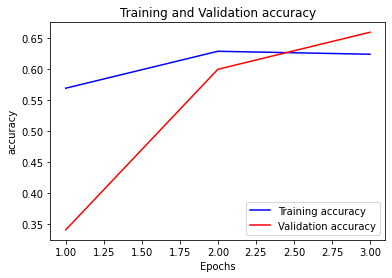

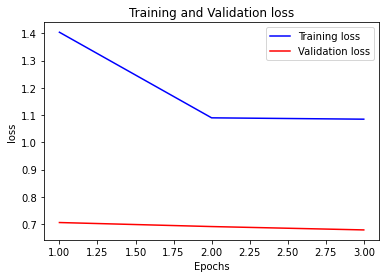

2/2 [==============================] - 0s 74ms/step
True labels: [1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0]
Predicted:   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


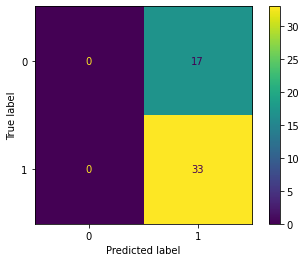

In [24]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plot_metric(epochs, acc, val_acc, 'accuracy')
# Plot loss
plot_metric(epochs, loss, val_loss, 'loss')


num_classes = 2
y_test_prediction_continuous = model_cnn.predict(test_set_x_n)
y_test_prediction = [round(x) for arr in y_test_prediction_continuous for x in arr]


# tf.compat.v1.disable_eager_execution() # this (in theory) avoids a warning message, more info in https://stackoverflow.com/questions/69136518/tensorflow-2-getting-warningtensorflowx-out-of-the-last-x-calls-to-function
print("\nTrue labels:", test_set_y[:30])
print("Predicted:  ", np.array(y_test_prediction[:30]).T)


#Your input to confusion_matrix must be an array of int NOT one hot encodings.
confusion_matrix_display = ConfusionMatrixDisplay.from_predictions(test_set_y, y_test_prediction)

# Pickling the model for deployment

In [ ]:
import pickle

pickle.dump(model_cnn, open('model_cnn2.pkl', 'wb'))

## Printing the version of TensorFlow and Keras so we can create a correspondent requirements.txt file

In [ ]:
!python3 -c "import tensorflow as tf; print(tf.__version__)"

2023-08-09 16:34:21.618093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.13.0


In [ ]:
!python3 -c "import keras; print(keras.__version__)"

2023-08-09 16:34:26.152871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.13.1
